# 14-1. 프로젝트: 이제까지 만들었던 모델을 튜닝하고 배포하기!

### 0. 모델 고정해서 사용하기  

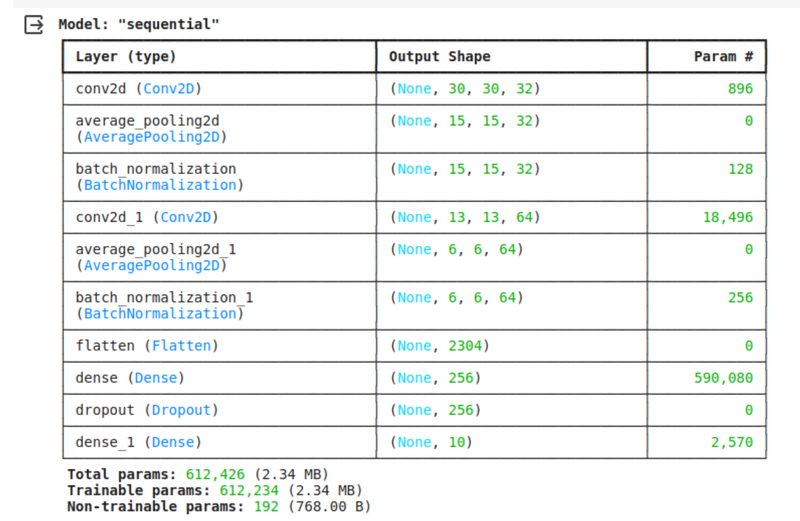

In [1]:
import os
import tensorflow as tf
import keras_tuner as kt

In [2]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, input_shape=(32,32,3)))
model.add(tf.keras.layers.AveragePooling2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, 3))
model.add(tf.keras.layers.AveragePooling2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 64)         0         
 ePooling2D)                                                     
                                                        

### 1. Data Centric AI 맛보기

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

wrong_labels = {2405:"frog", 6877:"ship", 8058:"horse", 7657:"horse", 2804:"cat", 1227:"dog", 5191:"dog", 5690:"deer", 1718:"ship", 2592:"deer", 4794:"bird", 5960:"cat", 9227:"truck", 5632:"dog", 9352:"truck", 7846:"cat", 6966:"ship", 5468:"cat"}
needRemove_labels = [2532, 1969, 6792, 165]

# 올바른 라벨로 수정
for index, correct_label in wrong_labels.items():
    y_test[index][0] = class_names.index(correct_label)

# 애매한 라벨 제거
for index in needRemove_labels:
    y_test[index] = -1


### 2. 하이퍼파라미터 튜닝

In [6]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

In [7]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = x_train.shape[1:], name = 'inputs'))
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32,64,128,256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    model.compile(optimizer = 'adam',loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [8]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

with tf.device('/gpu:0'):
    my_keras_tuner.search(
        x_train, y_train, validation_data=(x_test, y_test), epochs=3)

Trial 10 Complete [00h 00m 57s]
accuracy: 0.5295000076293945

Best accuracy So Far: 0.678600013256073
Total elapsed time: 00h 09m 38s


In [9]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 30, 30, 102)       2856      
                                                                 
 conv2d_68 (Conv2D)          (None, 28, 28, 42)        38598     
                                                                 
 conv2d_69 (Conv2D)          (None, 26, 26, 67)        25393     
                                                                 
 conv2d_70 (Conv2D)          (None, 24, 24, 37)        22348     
                                                                 
 conv2d_71 (Conv2D)          (None, 22, 22, 52)        17368     
                                                                 
 flatten_12 (Flatten)        (None, 25168)             0         
                                                                 
 dense_18 (Dense)            (None, 256)             

In [10]:
with tf.device('/gpu:0'):
    model.fit(x_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4343 - accuracy: 0.4799
Epoch 2/5
1563/1563 [==============================] - 12s 7ms/step - loss: 0.9976 - accuracy: 0.6486
Epoch 3/5
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7597 - accuracy: 0.7339
Epoch 4/5
1563/1563 [==============================] - 12s 7ms/step - loss: 0.5379 - accuracy: 0.8115
Epoch 5/5
1563/1563 [==============================] - 12s 7ms/step - loss: 0.3229 - accuracy: 0.8857


In [11]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.6645


[nan, 0.6644999980926514]

In [12]:
save_path = '.'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


### 3. 모델 배포하기 (옵션)

##### TFServing Docker로 배포

### 4. TFLite 모델 만들기 (옵션)

In [13]:
load_path ='./model'
best_model = tf.keras.models.load_model(load_path)

In [14]:
best_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 30, 30, 102)       2856      
                                                                 
 conv2d_68 (Conv2D)          (None, 28, 28, 42)        38598     
                                                                 
 conv2d_69 (Conv2D)          (None, 26, 26, 67)        25393     
                                                                 
 conv2d_70 (Conv2D)          (None, 24, 24, 37)        22348     
                                                                 
 conv2d_71 (Conv2D)          (None, 22, 22, 52)        17368     
                                                                 
 flatten_12 (Flatten)        (None, 25168)             0         
                                                                 
 dense_18 (Dense)            (None, 256)             

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp6a5wmx43\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp6a5wmx43\assets


In [16]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [17]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['inputs'], 'outputs': ['outputs']}}


In [18]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite